In [53]:
import uproot
import uproot_methods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    
%matplotlib inline
import matplotlib
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

In [37]:
energy = 850
fm = uproot.open('/store17/petrov/data/kskl_sim_custom/tr_ph_v7/tr_ph_kskl_1.9.root')
fe = uproot.open('root://cmd//scan2019/scan2019_tr_ph_fc_e550_v7.root')

In [45]:
def get_table(file):
    return file['tr_ph'].pandas.df(branches=['tptot', 'nt', 'tdedx', 'tz', 'tth', 'tphi', 'tnhit', \
                                          'tchi2r', 'tchi2z', 'trho', 'emeas'])
def piDeDx(P):
    return 5.58030e+9 / np.power(P + 40., 3) + 2.21228e+3 - 3.77103e-1 * P;
def go(fm):
    pmin_cut = 40
    pmax_cut = 1.1*energy
    z_cut = 10
    theta_cut = 0.6
    theta2_cut = np.pi - theta_cut
    hit_cut = 6
    chi2r_cut = 30
    chi2z_cut = 25
    rho_cut = 0.1
    df = get_table(fm)
    df2 = df.query('nt>=2&tptot>@pmin_cut&\
    tptot<@pmax_cut&\
    abs(tz)<@z_cut&\
    tchi2r<@chi2r_cut&\
    tchi2z<@chi2z_cut&\
    tth>@theta_cut&tth<@theta2_cut&\
    tnhit>@hit_cut&\
    abs(trho)>@rho_cut')
    drop_entries = df2.groupby('entry').agg({'tz':'count'}).query('tz!=2').index
    df3 = df2.drop(index=drop_entries, level=0)
    df6 = df3.query('tdedx<16000')
    df4 = df3.assign(dedx_cut=piDeDx(df3['tptot'])-df3['tdedx']).query( 'abs( dedx_cut ) < 2000' )
    drop_events = df4.groupby('entry').agg({'tz':'count'}).query('tz!=2').index
    df4 = df4.drop(index=drop_events, level=0)
    return df4

In [46]:
df4 = go(fm)

In [71]:
df4['vec'] = uproot_methods.TLorentzVectorArray.from_spherical(df4.tptot, df4.tth, df4.tphi, 139.57)

In [72]:
df4.head()

tptot  nt        tdedx        tz       tth      tphi  \
entry subentry                                                              
1     0         322.294281   2  1919.164673  0.534424  1.177708  5.391969   
      1         179.700378   2  2366.825439  1.308247  0.967115  2.792605   
15    0         620.633423   2  1678.835571 -0.174393  1.510463  0.806211   
      1         222.828949   2  2458.941406 -0.066984  1.721356  1.885062   
16    0         182.641296   2  2114.601562 -0.188929  1.755558  2.319368   

                tnhit    tchi2r    tchi2z      trho  emeas    dedx_cut  \
entry subentry                                                           
1     0            23  0.982555  0.831758 -0.247670  950.0  288.924683   
      1            16  0.930565  0.333817  0.591212  950.0  303.906250   
15    0            21  1.418873  0.940769  0.258209  950.0  318.755981   
      1            20  0.875775  0.457816 -0.799492  950.0  -23.337646   
16    0            27  1.879934  0.953420  0.502218  950.0  534.442627   

                                                              vec  
entry subentry                                                     
1     0         TLorentzVector(x=187.1, y=-231.57, z=123.45, t...  
      1         TLorentzVector(x=-139.02, y=50.587, z=102.01, ...  
15    0         TLorentzVector(x=428.84, y=447.08, z=37.422, t...  
      1         TLorentzVector(x=-68.101, y=209.52, z=-33.422,...  
16    0         TLorentzVector(x=-122.19, y=131.54, z=-33.553,...

In [74]:
df4.groupby('entry').agg({'vec': 'sum'})

,vec
entry,
1,"TLorentzVector(x=48.082, y=-180.99, z=225.46, ..."
15,"TLorentzVector(x=360.74, y=656.6, z=3.9998, t=..."
16,"TLorentzVector(x=-119.52, y=-104.63, z=-255.82..."
19,"TLorentzVector(x=-109.67, y=0.85312, z=291.01,..."
23,"TLorentzVector(x=-196.28, y=-752.47, z=132.31,..."
...,...
19980,"TLorentzVector(x=619.34, y=59.696, z=-483.46, ..."
19981,"TLorentzVector(x=-137.27, y=-60.215, z=212.76,..."
19992,"TLorentzVector(x=-43.795, y=117.27, z=-406.58,..."


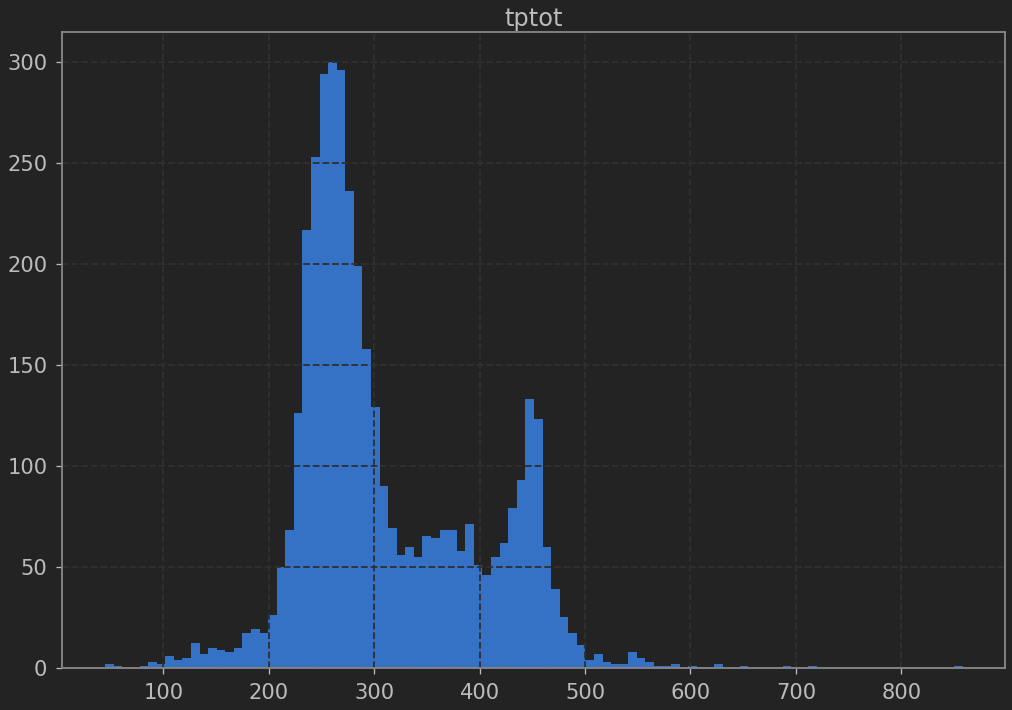

In [48]:
df4.groupby('entry').agg({'tptot':'mean'}).hist(bins=100);